# SHAP値の計算
https://shap.readthedocs.io/en/latest/index.html

In [3]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap

from IPython.display import display

# print the JS visualization code to the notebook
shap.initjs()

In [5]:
#display=Trueラベル変換前のデータ
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

display(X.head())
display(X_display.head())

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [13]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=200)

Training until validation scores don't improve for 50 rounds
[200]	valid_0's binary_logloss: 0.284763
[400]	valid_0's binary_logloss: 0.279539
[600]	valid_0's binary_logloss: 0.278211
Early stopping, best iteration is:
[644]	valid_0's binary_logloss: 0.278029


## shap値の計算

おそらく分類タスクでは以下のwarningが出力される。

```
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
```

In [14]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [15]:
#基準値の確認
print(explainer.expected_value)

[2.4326672543732544, -2.4326672543732544]


## Explain Predictions
基準値`explainer.expected_value`から各特徴量がどのように効いているのかを可視化する。

In [19]:
#idxでレコードを特定する
idx=0
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], X_display.iloc[idx,:])

In [20]:
#レコードを特定しない場合 （=複数レコード）
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X_display.iloc[:1000,:])

## Summary plot
予測版feature importanceのようなもの。  
検証データに対し、各特徴量がそれぞれモデルの出力にどのような影響を与えたのか出力する。
検証データそれぞれの各特徴のSHAP値の密度散布図を用いて算出される。

### feature importanceとの比較
* Relationshipはどちらの場合も一番高い
* Capital GainとAgeが大きく入れ替わっている

Capital Gainが重要なデータの場合、年齢よりもCapital Gainの影響が高い。  
つまり、
* Capital gainは少数のデータに大きな影響を与える。
* 一方、Ageは広く小さな影響を与える。

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

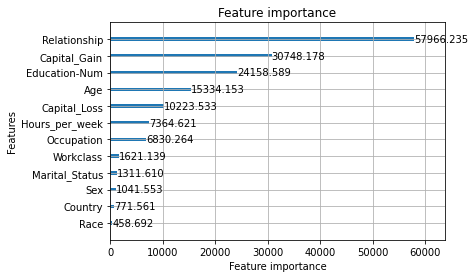

In [25]:
lgb.plot_importance(model, importance_type="gain")

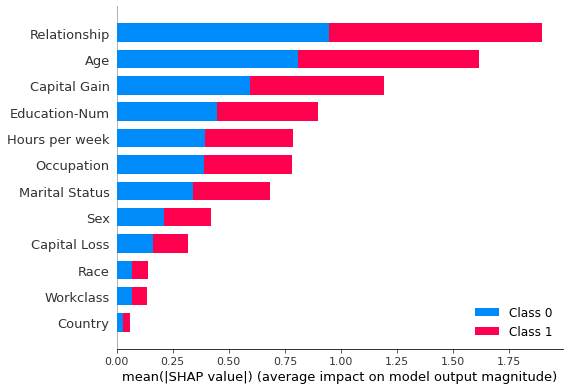

In [26]:
shap.summary_plot(shap_values, X)

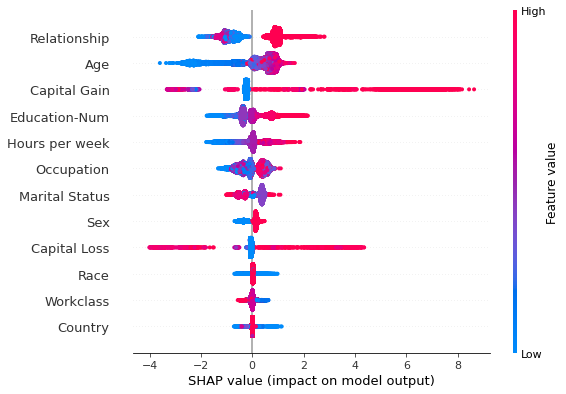

In [28]:
#dot表記もある
#Multiクラスの場合、一つしか描画できないので注意
shap.summary_plot(shap_values[1], X, plot_type="dot")

### Dependence Plots
特定の特徴量とShap値の相関を示す

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


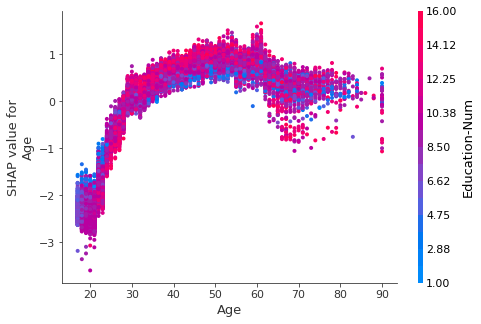

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


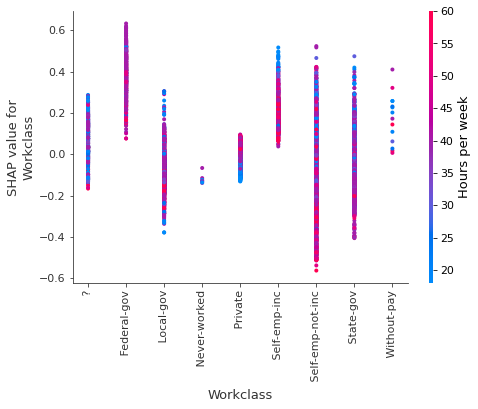

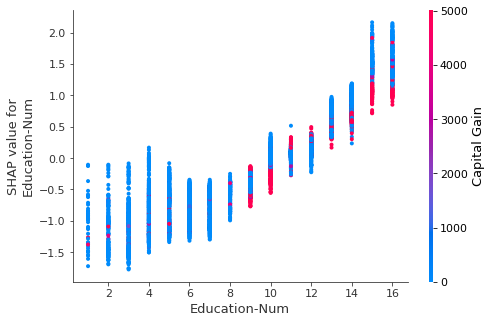

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


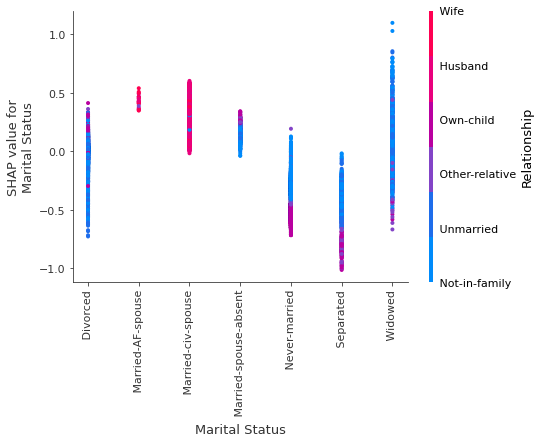

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


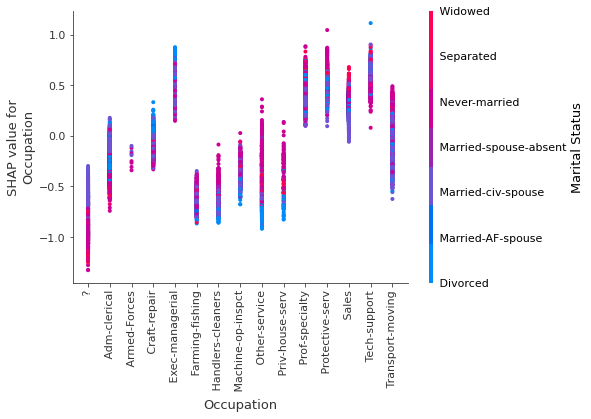

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


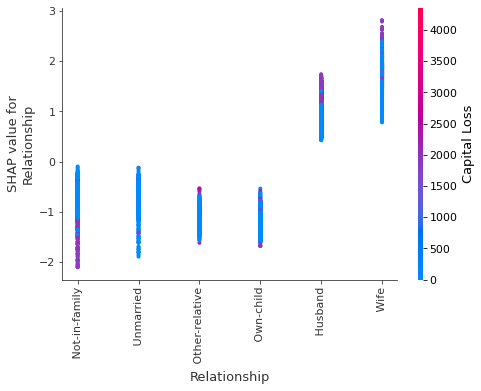

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


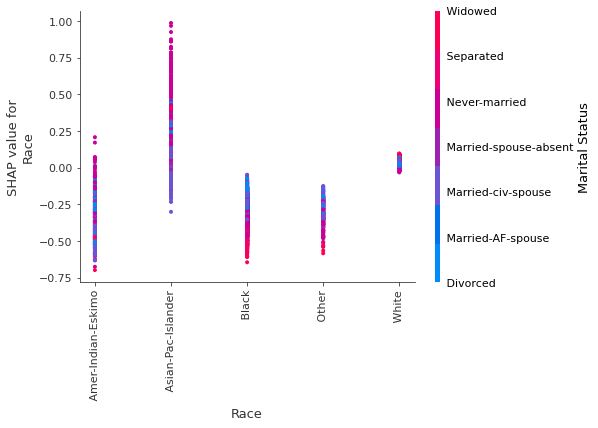

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


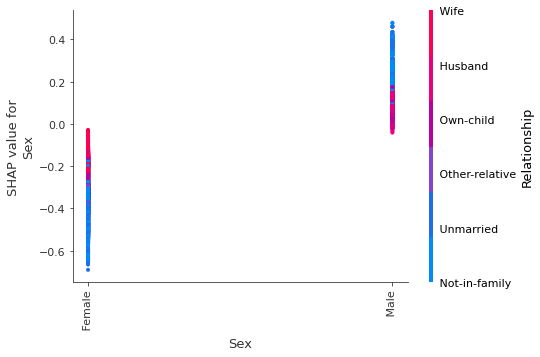

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


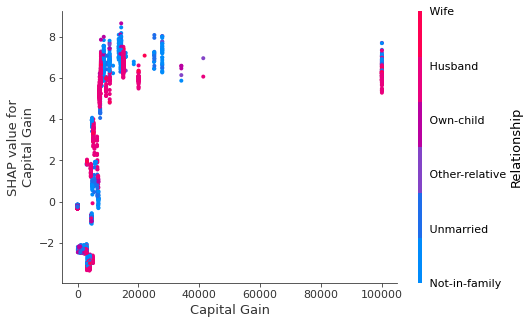

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


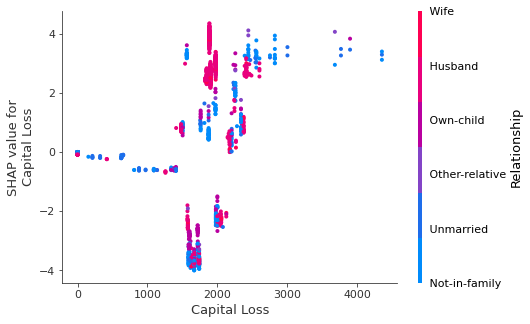

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


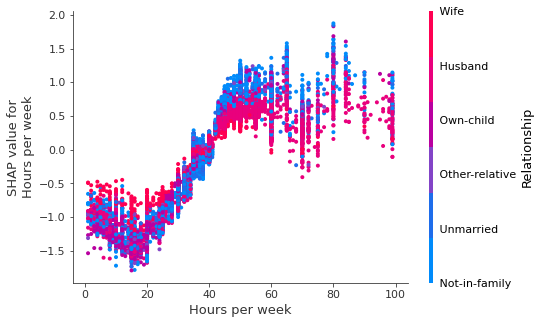

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


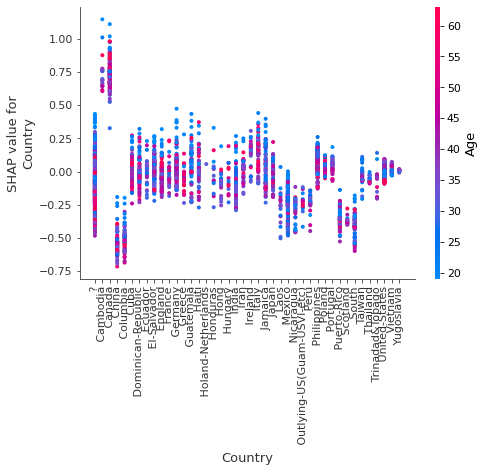

In [29]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[1], X, display_features=X_display)
